In [2]:
!pip install pennylane-qchem

In [0]:
import numpy as np
import pennylane as qml
from pennylane import expval, var, device

In [21]:
name ='LiH';charge = 0; multiplicity=1; basis= 'sto-3g'; geometry = 'lih.xyz';
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis,
    mapping='jordan_wigner',
    n_active_orbitals=3,
    n_active_electrons=2,
)
print(h, '\n', nr_qubits)

(-7.189117345981003) [I0]
+ (0.02498336736064769) [Z0]
+ (0.0048735920105351035) [Y0 Z1 Y2]
+ (0.0048735920105351035) [X0 Z1 X2]
+ (0.024983367360647678) [Z1]
+ (0.0048735920105351035) [Y1 Z2 Y3]
+ (0.0048735920105351035) [X1 Z2 X3]
+ (-0.13300290682418384) [Z2]
+ (-0.1330029068241838) [Z3]
+ (-0.1445363855022916) [Z4]
+ (-0.1445363855022916) [Z5]
+ (0.13106579035624258) [Z0 Z1]
+ (0.009702948635503639) [Y0 Y2]
+ (0.009702948635503639) [X0 X2]
+ (0.009702948635503639) [Z0 Y1 Z2 Y3]
+ (0.009702948635503639) [Z0 X1 Z2 X3]
+ (0.002366478148280204) [Y0 X1 X2 Y3]
+ (-0.002366478148280204) [Y0 Y1 X2 X3]
+ (-0.002366478148280204) [X0 X1 Y2 Y3]
+ (0.002366478148280204) [X0 Y1 Y2 X3]
+ (0.006795526682425653) [Y0 X1 X4 Y5]
+ (-0.006795526682425653) [Y0 Y1 X4 X5]
+ (-0.006795526682425653) [X0 X1 Y4 Y5]
+ (0.006795526682425653) [X0 Y1 Y4 X5]
+ (0.05929524181655196) [Z0 Z2]
+ (0.06166171996483217) [Z0 Z3]
+ (0.00034735301058658473) [Y0 Z1 Y2 Z3]
+ (0.00034735301058658473) [X0 Z1 X2 Z3]
+ (0.0048895

In [0]:
dev = qml.device("default.qubit", wires=6)

def circuit(params, wires=[0,1,2,3,4,5]):
    for i in wires:
        qml.RY(params[i], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[4], wires[5]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[3], wires[4]])
    for i in wires:
        qml.RY(params[i+6], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[4], wires[5]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[3], wires[4]])

In [0]:
qnodes = qml.map(circuit, h.ops, dev, measure='expval')
expval = qml.dot([h.coeffs], qnodes)

In [0]:
step_size = 0.4
max_iterations = 400
conv_tol = 1e-06

print_freq = 20

initial_params = np.random.uniform(low=0, high=2*np.pi, size=12)

In [15]:
params = initial_params
prev_energy = expval(params)
qng_energies_block = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)

    energy = expval(params)
    qng_energies_block.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:}'.format(n), 'Energy =', energy, 'Ha', 'Convergence parameter =', conv, 'Ha')

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Final convergence parameter =', conv)
print('Final value of the ground-state energy = ', energy)
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', n)

Iteration = 0 Energy = [-7.2922539] Ha Convergence parameter = [0.18704582] Ha
Iteration = 20 Energy = [-7.6064532] Ha Convergence parameter = [0.00074791] Ha
Iteration = 40 Energy = [-7.61148202] Ha Convergence parameter = [6.34958078e-05] Ha
Iteration = 60 Energy = [-7.61204198] Ha Convergence parameter = [1.51635766e-05] Ha
Iteration = 80 Energy = [-7.61234379] Ha Convergence parameter = [1.67527172e-05] Ha
Iteration = 100 Energy = [-7.6127408] Ha Convergence parameter = [2.27127923e-05] Ha
Iteration = 120 Energy = [-7.61325065] Ha Convergence parameter = [2.77002327e-05] Ha
Iteration = 140 Energy = [-7.6138386] Ha Convergence parameter = [3.06199046e-05] Ha
Iteration = 160 Energy = [-7.61446618] Ha Convergence parameter = [3.18280649e-05] Ha
Iteration = 180 Energy = [-7.61510236] Ha Convergence parameter = [3.15542854e-05] Ha
Iteration = 200 Energy = [-7.61571735] Ha Convergence parameter = [2.979545e-05] Ha
Iteration = 220 Energy = [-7.61628358] Ha Convergence parameter = [2.68126

In [31]:
params = initial_params
prev_energy = expval(params)
qng_energies_diag = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params], diag_approx=True)),
                                         grad_at_point)

    energy = expval(params)
    qng_energies_diag.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:}'.format(n), 'Energy =', energy, 'Ha', 'Convergence parameter =', conv, 'Ha')
   
    if conv <= conv_tol:
        qng_diag_steps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter =', conv)
print('Final value of the ground-state energy = ', energy)
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', n)

Iteration = 0 Energy = [-7.27765365] Ha Convergence parameter = [0.23015041] Ha
Iteration = 20 Energy = [-7.74570958] Ha Convergence parameter = [0.00302031] Ha
Iteration = 40 Energy = [-7.76535707] Ha Convergence parameter = [0.00024679] Ha
Iteration = 60 Energy = [-7.7671507] Ha Convergence parameter = [2.41558792e-05] Ha
Iteration = 80 Energy = [-7.76733481] Ha Convergence parameter = [2.78237134e-06] Ha

Final convergence parameter = [9.32091385e-07]
Final value of the ground-state energy =  [-7.76735241]

Final circuit parameters = 
 [ 3.14164093e+00  2.57859762e+00  4.73071874e+00  1.57083381e+00
  4.71238905e+00  1.58221914e+00 -1.89855968e-04  6.84629933e+00
  4.69622231e+00  4.71238951e+00  1.57079630e+00 -1.57078076e+00]
Number of iterations =  91


In [32]:
params = initial_params
prev_energy = expval(params)
vanilla_energies = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(step_size, grad_at_point)

    energy = expval(params)
    vanilla_energies.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:}'.format(n), 'Energy =', energy, 'Ha', 'Convergence parameter =', conv, 'Ha')

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Final convergence parameter =', conv)
print('Final value of the ground-state energy = ', energy)
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', n)

Iteration = 0 Energy = [-7.075] Ha Convergence parameter = [0.02749675] Ha
Iteration = 20 Energy = [-7.39745616] Ha Convergence parameter = [0.00874451] Ha
Iteration = 40 Energy = [-7.51891014] Ha Convergence parameter = [0.00446219] Ha
Iteration = 60 Energy = [-7.58679999] Ha Convergence parameter = [0.00263348] Ha
Iteration = 80 Energy = [-7.62992271] Ha Convergence parameter = [0.00184162] Ha
Iteration = 100 Energy = [-7.66290429] Ha Convergence parameter = [0.00150765] Ha
Iteration = 120 Energy = [-7.69023571] Ha Convergence parameter = [0.00123095] Ha
Iteration = 140 Energy = [-7.71148148] Ha Convergence parameter = [0.00090742] Ha
Iteration = 160 Energy = [-7.7265063] Ha Convergence parameter = [0.00062306] Ha
Iteration = 180 Energy = [-7.73678492] Ha Convergence parameter = [0.00042904] Ha
Iteration = 200 Energy = [-7.74398752] Ha Convergence parameter = [0.00030654] Ha
Iteration = 220 Energy = [-7.74922667] Ha Convergence parameter = [0.00022665] Ha
Iteration = 240 Energy = [-7

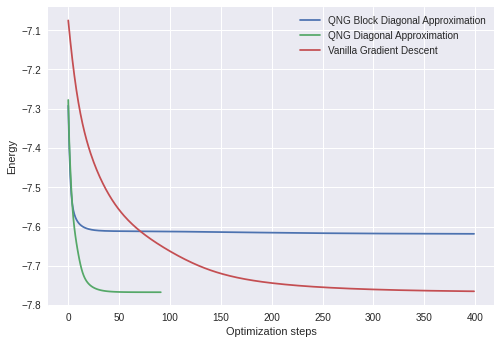

In [33]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(qng_energies_block, label="QNG Block Diagonal Approximation")
plt.plot(qng_energies_diag, label="QNG Diagonal Approximation")
plt.plot(vanilla_energies, label="Vanilla Gradient Descent")

plt.ylabel("Energy")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()